In [2]:
import os
import os.path as osp
import sys
import torch
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import random
import math
import pickle
import json
import time
import re
import pickle
from Bio import SeqIO
from tqdm import tqdm
%matplotlib inline
import sklearn.metrics as metrics
from torch_geometric.nn import MessagePassing, SAGEConv
from torch import nn
from scipy.stats import norm
from networkx.algorithms import bipartite
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification

In [3]:
root_dir = '/mnt/data2024/hrren/Settle_code'
df = pd.read_csv(osp.join(root_dir, 'AAAAAFillfinalmatrix.csv'))

In [7]:
pos = df[df['Label'] == 1]
tf_target_genes = set(pos['TF']).union(set(pos['Target']))
label_0_rows = df[df['Label'] == 0]
neg = label_0_rows[label_0_rows['TF'].isin(tf_target_genes) | label_0_rows['Target'].isin(tf_target_genes)]
unique_TF = pos['TF'].nunique()
unique_genes = pos['Target'].nunique()
unique_TF


262

In [8]:
# 先采样一个三比一的数据集
pos_indices = pos.index.tolist()
neg_indices = neg.index.tolist()
len(neg_indices),len(pos_indices)
ratio = 100
number = len(pos_indices)*ratio
neg_sampled = random.sample(neg_indices,number)
selected_label_1_data = df.loc[pos_indices]
selected_label_0_data = df.loc[neg_sampled]
df2 = pd.concat([selected_label_1_data, selected_label_0_data])

In [9]:
df2 = pd.concat([pos, neg])
length_ok = [ind for ind, s in enumerate(df2['Target_promoter'].tolist()) if len(s) == 2500]
df2 = df2.iloc[length_ok]

In [12]:
class VocabForKmer():
    def __init__(self, kmer=6, reserved_tokens=None):
        from itertools import product
        self.kmer = kmer
        kmer_iter = product('ACGT', repeat=kmer)
        words = [''.join(i) for i in kmer_iter]

        if reserved_tokens is None:
            reserved_tokens = []
        self.idx_to_token = ['<unk>'] + reserved_tokens + words
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}
        
    def __len__(self):
        return len(self.idx_to_token)
        
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]
    
    @property
    def unk(self):  # 未知词元的索引为0
        return 0
class BERTEncoder(nn.Module):
    def __init__(self, vocab_size, d_model, n_head, dim_feedforward=1024, dropout=0.1, 
                 num_layers=12, max_len=512, activation='relu', norm_first=False, 
                 discard_segment=False, **kwargs):
        super(BERTEncoder, self).__init__(**kwargs)
        self.discard_segment = discard_segment
        self.max_len = max_len
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.segment_embedding = nn.Embedding(2, d_model) if not self.discard_segment else None
        self.position_embedding = nn.Embedding(max_len, d_model)
        self.tfencoders = nn.Sequential()
        for i in range(num_layers):
            self.tfencoders.add_module(f'layer_{i}', nn.TransformerEncoderLayer(d_model=d_model, 
                                                                                nhead=n_head,
                                                                                dim_feedforward=dim_feedforward,
                                                                                dropout=dropout,
                                                                                activation=activation,
                                                                                norm_first=norm_first,
                                                                                batch_first=True))

    def forward(self, tokens, segments=None, token_key_padding_mask=None):

        X = self.token_embedding(tokens)
        if not self.discard_segment and segments is not None:
            X = X + self.segment_embedding(segments)
        X = X + self.position_embedding(torch.arange(self.max_len, dtype=torch.long).to(torch.device(X.device))).unsqueeze(0)
        for blk in self.tfencoders:
            if token_key_padding_mask is not None:
                X = blk(X, src_key_padding_mask=token_key_padding_mask)
            else:
                X = blk(X)
        return X


class MaskedLM(nn.Module):

    def __init__(self, vocab_size, num_hiddens=768, num_inputs=768, activation='relu', **kwargs):
        super(MaskedLM, self).__init__(**kwargs)
        self.fc1 = nn.Linear(num_inputs, num_hiddens)
        self.activation = nn.ReLU() if activation == 'relu' else nn.GELU()
        self.fc2 = nn.Linear(num_hiddens, vocab_size)                

    def forward(self, X, pred_positions): 
        num_pred_positions = pred_positions.shape[1]
        # print('1', num_pred_positions)
        pred_positions = pred_positions.reshape(-1)
        # print('2', pred_positions.shape)
        batch_size = X.shape[0]
        # print('3', batch_size)
        batch_idx = torch.arange(0, batch_size)
        # print('4', batch_idx.shape)
        batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)
        # print('5', batch_idx.shape)
        masked_X = X[batch_idx, pred_positions]
        # print('6', masked_X.shape)
        masked_X = masked_X.reshape((batch_size, num_pred_positions, -1))
        # print('7', masked_X.shape)
        # mlm_Y_hat = self.mlp(masked_X)
        mlm_Y_hat = self.fc2(self.activation(self.fc1(masked_X)))
        return mlm_Y_hat


class BERTModel(nn.Module):
    def __init__(self, vocab_size, d_model, n_head, dim_feedforward=1024, dropout=0.1, 
                 num_layers=12, max_len=512, activation='relu', norm_first=False, 
                 discard_segment=False, dim_mlm_hidden=768, **kwargs):
        super(BERTModel, self).__init__(**kwargs)
        self.tfencoder = BERTEncoder(vocab_size=vocab_size, d_model=d_model, n_head=n_head, 
                 dim_feedforward=dim_feedforward, dropout=dropout, num_layers=num_layers, 
                 max_len=max_len, activation=activation, norm_first=norm_first, 
                 discard_segment=discard_segment)
        self.mlm = MaskedLM(vocab_size=vocab_size, num_hiddens=dim_mlm_hidden, 
                            num_inputs=d_model, activation=activation)
        self._init_weight()
        # fc2 is shared with embedding layer
        self.mlm.fc2.weight = self.tfencoder.token_embedding.weight

    def forward(self, tokens, segments=None, token_key_padding_mask=None, pred_positions=None):
        tfencoder_X = self.tfencoder(tokens, segments, token_key_padding_mask)
        mlm_Y_hat = self.mlm(tfencoder_X, pred_positions)
        return mlm_Y_hat
    
    def get_emb(self, tokens, segments=None, token_key_padding_mask=None):
        tfencoder_X = self.tfencoder(tokens, segments, token_key_padding_mask)
        return tfencoder_X

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Embedding):
                nn.init.normal_(m.weight, mean=0, std=0.02)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)

In [13]:
pretrained_model = '/mnt/data2024/hrren/Settle_code/prot_bert_model'
# BERT_encoder = AutoModel.from_pretrained(pretrained_model, local_files_only=True, output_attentions=False).to(device)
pep_tokenizer = AutoTokenizer.from_pretrained(pretrained_model, do_lower_case=False, use_fast=False) 
print(pep_tokenizer.get_vocab()), len(pep_tokenizer.get_vocab())
gpu = 2
device = torch.device(f'cuda:{gpu}' if torch.cuda.is_available() else 'cpu')
KMER_SIZE = 6
MAX_LEN = 2000
vocab = VocabForKmer(kmer=KMER_SIZE, reserved_tokens=['<pad>', '<mask>', '<cls>', '<sep>'])
len(vocab)

{'[PAD]': 0, '[UNK]': 1, '[CLS]': 2, '[SEP]': 3, '[MASK]': 4, 'L': 5, 'A': 6, 'G': 7, 'V': 8, 'E': 9, 'S': 10, 'I': 11, 'K': 12, 'R': 13, 'D': 14, 'T': 15, 'P': 16, 'N': 17, 'Q': 18, 'F': 19, 'Y': 20, 'M': 21, 'H': 22, 'C': 23, 'W': 24, 'X': 25, 'U': 26, 'B': 27, 'Z': 28, 'O': 29}


4101

In [14]:
test_ratio = 0.1
TF_set = df2['TF'].unique().tolist()
target_set = df2['Target'].unique().tolist()
target_set = list(set(target_set)-set(TF_set))
test_TF = random.sample(TF_set, int(len(TF_set)*test_ratio))
print(f"Test TF {len(test_TF)} for {len(df2[df2['TF'].isin(test_TF)])} interactions")
train_TF = list(set(TF_set)-set(test_TF))
print(f"Train TF {len(train_TF)} for {len(df2[df2['TF'].isin(train_TF)])} interactions")
bool_list = []
for ind, row in df2.iterrows():
    if row.iloc[0] in train_TF:
        bool_list.append(True)
    else:
        assert row.iloc[0] in test_TF
        bool_list.append(False)
df2.loc[:, ['training']] = bool_list

Test TF 186 for 32454 interactions
Train TF 1679 for 312875 interactions


In [15]:
node_tf_ID = df2['TF'].unique().tolist()
TFnode_2_ID_dict = {node:ind for ind, node in enumerate(node_tf_ID)}
json_TFnode_map = osp.join('TF_node_mapping_dict.pkl')
json.dump(TFnode_2_ID_dict, open(json_TFnode_map, 'w'), indent=4, sort_keys=False, ensure_ascii=False)
node_target_ID = df2['Target'].unique().tolist()
target_node_2_ID_dict  = {node:ind for ind, node in enumerate(node_target_ID)}
json_targetnode_map = osp.join('target_node_mapping_dict.pkl')
json.dump(target_node_2_ID_dict, open(json_targetnode_map, 'w'), indent=4, sort_keys=False, ensure_ascii=False)
len(TFnode_2_ID_dict), len(target_node_2_ID_dict)

(1865, 30787)

In [16]:
MAX_LEN = 2500
TF_token_dict = {}
TF_token_mask_dict = {}
for node in tqdm(node_tf_ID):
    node_type_column = 'TF'
    seq_column = 'TF_pep'
    seq = df[df[node_type_column]==node][seq_column].unique()[0]
    encoded =pep_tokenizer(' '.join(seq),add_special_tokens=True,padding='max_length', return_token_type_ids=False, truncation=True, max_length=1000, return_tensors='np')
    token = encoded['input_ids']
    attention_mask = encoded['attention_mask']
    token_key_padding_mask = torch.tensor([False] * len(seq) + [True] * (MAX_LEN - len(seq)), dtype=torch.bool).to(device).unsqueeze(0)
    token = np.array(token)
    TF_token_dict[node] = token
    TF_token_mask_dict[node] = token_key_padding_mask

100%|██████████| 1865/1865 [01:58<00:00, 15.75it/s]


In [17]:
def seq2kmer(seq, kmer=6):
    '''kmer_seq is `seqlen - kmer_size + 1`'''
    kmers = []
    for ind in range(len(seq)):
        if ind+kmer > len(seq):
            break
        k = seq[ind:ind+kmer]
        kmers.append(''.join(k))
    return kmers

In [18]:
target_token_dict = {}
target_token_mask_dict = {}
for node in tqdm(node_target_ID):
    node_type_column = 'Target'
    seq_column = 'Target_promoter'
    seq = df[df[node_type_column]==node][seq_column].unique()[0]
    kmer_seq = seq2kmer(seq, KMER_SIZE)
    tokens = kmer_seq
    tokens = np.array(vocab[tokens] + [vocab['<pad>']] * (2500 -len(tokens)))
    token_key_padding_mask = np.array([False] * len(kmer_seq) + [True] * (MAX_LEN - len(kmer_seq)))
    target_token_dict[node] = tokens
    target_token_mask_dict[node] = token_key_padding_mask
# with open('token_dict.pkl', 'rb') as f:
#     target_token_dict = pickle.load(f)
#     target_token_mask_dict = pickle.load(f)

100%|██████████| 30787/30787 [32:20<00:00, 15.86it/s]


In [19]:
# 生成节点的张量；节点token，布尔值，掩码
def tokenizer(nodedict, train_TF, token_dict, token_mask_dict):
    node_token = []
    node_bool = []
    node_mask = []
    for node, ID in nodedict.items():
        node_token.append(token_dict[node])
        if isinstance(token_mask_dict[node], torch.Tensor):
            node_mask.append(token_mask_dict[node].squeeze().cpu().numpy())
        else:
            node_mask.append(token_mask_dict[node].squeeze())
        if node in train_TF:
            training = True
        else:
            training = False
        node_bool.append(training)
    return node_token, node_bool, node_mask
node_left, node_left_bool, node_left_mask = tokenizer(TFnode_2_ID_dict, train_TF, TF_token_dict, TF_token_mask_dict)
node_right, node_right_bool, node_right_mask = tokenizer(target_node_2_ID_dict, train_TF, target_token_dict, target_token_mask_dict)
node_left = torch.tensor(node_left, dtype=torch.float32).to(device)
node_left_bool = torch.tensor(node_left_bool, dtype=torch.float32).to(device)
node_left_mask  = torch.tensor(node_left_mask, dtype=torch.float32).to(device)
node_right = torch.tensor(node_right, dtype=torch.float32).to(device)
node_right_bool = torch.tensor(node_right_bool, dtype=torch.float32).to(device)
node_right_mask  = torch.tensor(node_right_mask, dtype=torch.float32).to(device)
len(node_left), len(node_right)

/tmp/ipykernel_2380654/1332257005.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  node_left = torch.tensor(node_left, dtype=torch.float32).to(device)


(1865, 30787)

In [20]:
edgelist = []
for data in tqdm(df2.iterrows()):
    data = data[-1]
    TF = TFnode_2_ID_dict[data['TF']]
    Target = target_node_2_ID_dict[data['Target']]
    edgelist.append([TF, Target])
edgelist = np.array(edgelist)
edge_label = df2['Label'].to_numpy()
edge_bool = np.array(df2['training'].to_numpy(), dtype=np.bool_)
edge_index = torch.tensor(edgelist, dtype=torch.long).t().to(device)
edge_label = torch.tensor(edge_label, dtype=torch.float).to(device)
edge_bool = torch.tensor(edge_bool, dtype=torch.bool).to(device)
edge_attr = torch.tensor(df2.loc[:, ['Edge_attr0', 'Edge_attr2', 'Edge_attr3', 'Edge_attr4',
    'Edge_attr5', 'Edge_attr7', 'Edge_attr8', 'Edge_attr9',
    'Edge_attr10', 'Edge_attr11', 'Edge_attr12', 'Edge_attr13', 'Edge_attr14',
    'Edge_attr15', 'Edge_attr16', 'Edge_attr17', 'Edge_attr18', 'Edge_attr19',
    'Edge_attr20', 'GENIE3', 'ATAC',
    'PWM', 'Chip', 'cPWM']].to_numpy(), dtype=torch.float).to(device)

345329it [00:12, 26852.79it/s]


In [21]:
node_left = torch.tensor(node_left, dtype=torch.float32).to(device)
node_left_bool = torch.tensor(node_left_bool, dtype=torch.float32).to(device)
node_left_mask  = torch.tensor(node_left_mask, dtype=torch.float32).to(device)
node_right = torch.tensor(node_right, dtype=torch.float32).to(device)
node_right_bool = torch.tensor(node_right_bool, dtype=torch.float32).to(device)
node_right_mask  = torch.tensor(node_right_mask, dtype=torch.float32).to(device)
edge_index = torch.tensor(edge_index, dtype=torch.long).to(device)
edge_label = torch.tensor(edge_label, dtype=torch.float).to(device)
edge_bool = torch.tensor(edge_bool, dtype=torch.bool).to(device)
edge_attr = torch.tensor(edge_attr, dtype=torch.float).to(device)

/tmp/ipykernel_2380654/1855557197.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node_left = torch.tensor(node_left, dtype=torch.float32).to(device)
/tmp/ipykernel_2380654/1855557197.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node_left_bool = torch.tensor(node_left_bool, dtype=torch.float32).to(device)
/tmp/ipykernel_2380654/1855557197.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node_left_mask  = torch.tensor(node_left_mask, dtype=torch.float32).to(device)
/tmp/ipykernel_2380654/1855557197.py:4: UserWarning: To copy 

In [22]:
class EdgeMLP(nn.Module):
    def __init__(self, edge_in_fea, edge_emd_fea, edge_out_fea):
        super(EdgeMLP, self).__init__()
        self.edge_updates = nn.Sequential(nn.Linear(edge_in_fea, edge_emd_fea), nn.ReLU())
        nn.Sequential(
            nn.Linear(edge_in_fea, edge_emd_fea), nn.ReLU(),
            nn.Linear(edge_emd_fea, edge_emd_fea), nn.ReLU(),
            nn.Linear(edge_emd_fea, edge_emd_fea), nn.ReLU(),
            nn.Linear(edge_emd_fea, edge_out_fea), nn.ReLU())
    
    def forward(self, edge_attr):
        for f in self.edge_updates:
            edge_attr = f(edge_attr)
        return edge_attr

class NodeMLP(nn.Module):
    def __init__(self, node_in_fea, node_emd_fea, node_out_fea):
        super(NodeMLP, self).__init__()
        self.node_updates = nn.Sequential(
            nn.Linear(node_in_fea, node_emd_fea), nn.ReLU(),
            nn.Linear(node_emd_fea, node_emd_fea), nn.ReLU(),
            nn.Linear(node_emd_fea, node_emd_fea), nn.ReLU(),
            nn.Linear(node_emd_fea, node_out_fea), nn.ReLU())
    
    def forward(self, x):
        for f in self.node_updates:
            x = f(x)
        return x

class BipartiteGraphOperator(MessagePassing):
    def __init__(self, dim1=256, dim2=256, dim_out=256, flow='source_to_target'):
        super().__init__()
#         super(BipartiteGraphOperator, self).__init__('add', 'source_to_target')
        self.flow = flow
        self.lin = torch.nn.Linear(dim1 + dim2, dim_out)

    def forward(self, x, assign_index, N, M,edge_attr=None):
        return self.propagate(assign_index, size=(N, M), x=x,edge_attr=edge_attr)

    def message(self, x_i, x_j,edge_attr=None):
        # print('Here:', x_i.shape, x_j.shape)
        return self.lin(torch.cat([x_i, x_j], dim=1))

class MPNNBlock(nn.Module):
    def __init__(self, TF_in=512, TF_hidden=1024, TF_out=512, target_in=2495, target_hidden=1024, target_out=512, edge_in=1, edge_hidden=1024, edge_out=256):
        super(MPNNBlock, self).__init__()
        self.left_model = NodeMLP(TF_in, TF_hidden, TF_out)
        self.right_model = NodeMLP(target_in, target_hidden, target_out)
        if edge_in is not None:
            if edge_in > 0:
                self.edge_model = EdgeMLP(edge_in, edge_hidden, edge_out)
        node_out = (TF_out + target_out) // 2
        self.mpnn_conv_src = BipartiteGraphOperator(dim1=TF_out, dim2=target_out, dim_out=node_out, flow='target_to_source')
        self.mpnn_conv_dest = BipartiteGraphOperator(dim1=TF_out, dim2=target_out, dim_out=node_out, flow='source_to_target')

    def forward(self, node_left, node_right, edge_index, edge_attr=None):
        node_left = self.left_model(node_left)
        node_right = self.right_model(node_right)
        if len(node_left.shape) == 3:
            node_left = node_left.mean(dim=1)
        if len(node_right.shape) == 3:
            node_right = node_right.mean(dim=1)
        if edge_attr is not None:
            edge_attr = self.edge_model(edge_attr)
        # print(len(node_left.shape), node_right.shape, node_left.shape, edge_attr.shape, edge_index.shape, node_left.size()[0], node_right.size()[0])
        if edge_attr is not None:
            # print(node_left.shape, node_right.shape)
            node_left = self.mpnn_conv_src((node_left, node_right), edge_index, N=node_left.shape[0], M=node_right.shape[0],edge_attr=edge_attr.mean(dim=1))
            node_right = self.mpnn_conv_dest((node_left, node_right), edge_index, N=node_left.shape[0], M=node_right.shape[0],edge_attr=edge_attr.mean(dim=1))
        else:
            node_left = self.mpnn_conv_src((node_left, node_right), edge_index, N=node_left.shape[0], M=node_right.shape[0])
            node_right = self.mpnn_conv_dest((node_left, node_right), edge_index, N=node_left.shape[0], M=node_right.shape[0])
        # print(node_left.shape, node_right.shape)
        return node_left, node_right, edge_attr

class MetaGNNLink(nn.Module):
    def __init__(self, vocab_size_left=20, vocab_size_right=20, num_gnn_layers=2, TF_in=16, TF_hidden=16, TF_out=16, target_in=16, target_hidden=16, target_out=16, edge_in=3, edge_hidden=16, edge_out=16):
        super().__init__()
        self.emb_left = torch.nn.Embedding(vocab_size_left, TF_in)
        self.emb_right = torch.nn.Embedding(vocab_size_right, target_in)
        self.gnn = nn.ModuleList([MPNNBlock(TF_in, TF_hidden, TF_out, target_in, target_hidden, target_out, edge_in, edge_hidden, edge_out),*[MPNNBlock(TF_out, TF_hidden, TF_out, target_out, target_hidden, target_out, edge_out, edge_hidden, edge_out) for i in range(num_gnn_layers)]])
        decoder_hidden = 64
        if edge_in is not None:
            if edge_in > 0:
                decode_in = TF_out+target_out+edge_out
        else:
            decode_in = TF_out+target_out
        self.decode_link = nn.Sequential(
            nn.Linear(decode_in, decoder_hidden), nn.ReLU(),
            nn.Linear(decoder_hidden, decoder_hidden//2), nn.ReLU(),
            nn.Linear(decoder_hidden//2, decoder_hidden//4), nn.ReLU(),
            nn.Linear(decoder_hidden//4, 1))

    def forward(self, node_left, node_right, edge_index, edge_attr=None):
        # print(node_left.shape, node_right.shape)
        node_left = self.emb_left(node_left.long().squeeze())
        # print(node_left.shape)
        node_right = self.emb_right(node_right.long().squeeze())
        # print(node_left.shape, node_right.shape)
        for f in self.gnn:
            # print(node_left.shape, node_right.shape, edge_attr.shape)
            node_left, node_right, edge_attr = f(node_left, node_right, edge_index, edge_attr)
            # print(node_left.sum().item(), node_right.sum().item(), edge_attr.sum().item())
        
        for i, f in enumerate(self.decode_link):
            if i == 0:
                if edge_attr is not None:
                    edge_concat = torch.cat([node_left[edge_index[0]], node_right[edge_index[1]], edge_attr], dim=1)
                else:
                    edge_concat = torch.cat([node_left[edge_index[0]], node_right[edge_index[1]]], dim=1)
                link_out = f(edge_concat)
            else:
                link_out = f(link_out)

        return link_out
    
    def decode(self, node_left, node_right, edge_index, edge_attr):
        link_out = self.cossim(node_left[edge_index[0]], node_right[edge_index[1]])
        return link_out
    
    def decode_linear(self, node_left, node_right, edge_index, edge_attr):
        for i, f in enumerate(self.decode_link):
            if i == 0:
                edge_concat = torch.cat([node_left[edge_index[0]], node_right[edge_index[1]], edge_attr], dim=1)
                link_out = f(edge_concat)
            else:
                link_out = f(link_out)
        
    def decode_edge(self, edge_attr):
        pass

In [33]:
gpu = 2
device = torch.device(f'cuda:{gpu}' if torch.cuda.is_available() else 'cpu')
model = MetaGNNLink(vocab_size_left=len(pep_tokenizer.get_vocab()), vocab_size_right=len(vocab), num_gnn_layers=3,target_in=32, TF_in=32, edge_in=edge_attr.shape[-1]).to(device)
criterion = torch.nn.BCEWithLogitsLoss().to(device) # pos_weight=edge_weight.squeeze()[edge_bool]
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, betas=(0.9, 0.98), eps=2e-5, weight_decay=1e-3)

In [40]:
NUM_TRAINING_EPOCHS = 300
minimum_loss = np.inf
best_roc = 0
best_epoch = 0
train_loss_list = []
test_loss_list = []
step = 0
cutoff = 0.1

# 检查数据泄漏
# assert len(set(node_left[edge_bool].numpy()).intersection(set(node_left[~edge_bool].numpy()))) == 0, "Training and validation sets overlap in node_left"
# assert len(set(node_right[edge_bool].numpy()).intersection(set(node_right[~edge_bool].numpy()))) == 0, "Training and validation sets overlap in node_right"

with tqdm(total=NUM_TRAINING_EPOCHS, desc=f'Training', ncols=120, postfix=dict, mininterval=0.3, colour="#99FFFF", bar_format='{l_bar}{bar}| [{n_fmt}/{total_fmt}{postfix}]') as pbar:
    for epoch in range(1, NUM_TRAINING_EPOCHS + 1):
        model.train()
        outputs = model(node_left, node_right, edge_index, edge_attr).squeeze()

        if outputs.ndim > 1:
            outputs = outputs.view(-1)

        logits = outputs[edge_bool]
        targets = edge_label[edge_bool]
        
        loss = criterion(logits, targets)
        train_loss = loss.item() / targets.shape[0]
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        step += 1
        train_loss_list.append(train_loss)
        pbar.set_postfix({'step': f"{epoch}", 'train loss': f"{train_loss:.4f}"})
        time.sleep(0.05)
        pbar.update(1)
        
        model.eval()
        with torch.no_grad():
            outputs = model(node_left, node_right, edge_index, edge_attr).squeeze()

            if outputs.ndim > 1:
                outputs = outputs.view(-1)

            test_logits = outputs[~edge_bool]
            test_targets = edge_label[~edge_bool]
            
            test_loss = criterion(test_logits, test_targets).item() / test_targets.shape[0]
            test_loss_list.append(test_loss)
            
            # 预测标签
            predict_label = (test_logits > cutoff).long()
            test_acc = (predict_label == test_targets).sum().item() / len(test_targets)
            
            # 计算AUC
            preds = test_logits.detach().cpu().numpy()
            fpr, tpr, threshold = metrics.roc_curve(test_targets.detach().cpu().numpy(), preds)
            roc_auc = metrics.auc(fpr, tpr)
        
        if roc_auc > best_roc:
            best_roc = roc_auc
            best_epoch = epoch
            best_logits = preds
            print(f"Epoch {epoch} | test loss avg: {test_loss:.4f} | test acc: {test_acc:.4f} | test auc: {best_roc:.4f}.")
        elif epoch % 100 == 0:
            print(f"Epoch {epoch} | test loss avg: {test_loss:.4f} | test acc: {test_acc:.4f} | test auc: {best_roc:.4f}.")

Training:   0%|▏                                                                    | [1/300, step=2, train loss=0.0002]

Epoch 1 | test loss avg: 0.0018 | test acc: 0.9938 | test auc: 0.6426.


Training:   1%|▍                                                                    | [2/300, step=3, train loss=0.0002]

Epoch 2 | test loss avg: 0.0018 | test acc: 0.9935 | test auc: 0.6801.


Training:  25%|████████████████▌                                                  | [74/300, step=75, train loss=0.0002]

Epoch 74 | test loss avg: 0.0015 | test acc: 0.9903 | test auc: 0.6948.


Training:  33%|█████████████████████▋                                           | [100/300, step=101, train loss=0.0019]

Epoch 100 | test loss avg: 0.0171 | test acc: 0.9985 | test auc: 0.6948.


Training:  48%|███████████████████████████████▍                                 | [145/300, step=146, train loss=0.0003]

Epoch 145 | test loss avg: 0.0030 | test acc: 0.9591 | test auc: 0.6979.


Training:  67%|███████████████████████████████████████████▎                     | [200/300, step=201, train loss=0.0001]

Epoch 200 | test loss avg: 0.0009 | test acc: 0.9984 | test auc: 0.6979.


Training:  75%|████████████████████████████████████████████████▉                | [226/300, step=227, train loss=0.0000]

Epoch 226 | test loss avg: 0.0003 | test acc: 0.9957 | test auc: 0.6980.


Training:  76%|█████████████████████████████████████████████████▍               | [228/300, step=229, train loss=0.0008]

Epoch 228 | test loss avg: 0.0088 | test acc: 0.9170 | test auc: 0.7293.


Training: 100%|█████████████████████████████████████████████████████████████████| [300/300, step=300, train loss=0.0001]

Epoch 300 | test loss avg: 0.0004 | test acc: 0.9983 | test auc: 0.7293.


In [35]:
# 打印形状以检查一致性
print(f"node_left shape: {node_left.shape}")
print(f"node_right shape: {node_right.shape}")
print(f"edge_bool shape: {edge_bool.shape}")

node_left shape: torch.Size([1865, 1, 1000])
node_right shape: torch.Size([30787, 2500])
edge_bool shape: torch.Size([345329])


In [39]:
pos


,TF,TF_pep,TF_cds,Target,Target_promoter,Edge_attr0,Edge_attr2,Edge_attr3,Edge_attr4,Edge_attr5,...,Edge_attr29,Edge_attr30,Edge_attr31,Edge_attr32,GENIE3,ATAC,PWM,Chip,Label,cPWM
1834770,LOC_Os03g60430,MLLDLNVESPERSGTSSSSVLNSGDAGGGGGGGGGGGLFRFDLLAS...,ATGTTGTTGGATCTCAATGTGGAGTCGCCGGAACGGTCCGGCACGT...,LOC_Os06g06760,GTGGCATCGCACTACACACACCACCCGTGAGGACTGAGGAGTCTCG...,0.684466,0.930658,0.031236,0.985271,0.683051,...,0.816782,0.690776,0.590202,0.350191,0.007306,0.761364,0.628816,0.000000,1.0,0.695014
1834771,LOC_Os03g60430,MLLDLNVESPERSGTSSSSVLNSGDAGGGGGGGGGGGLFRFDLLAS...,ATGTTGTTGGATCTCAATGTGGAGTCGCCGGAACGGTCCGGCACGT...,LOC_Os12g44360,TCAAAACTTCCAAACGACACGTGTTTTTTTAAAAAATCTACCTAGA...,0.743212,0.857745,0.999184,0.950132,0.682092,...,0.605103,0.024517,0.999660,0.834553,0.005444,0.761364,0.695014,0.000000,1.0,0.683667
1834772,LOC_Os06g43220,MCRDCGKQVYLGGFDTAQAAARAYDQAAIKFRGVEADINFTLDDYK...,ATGTGCAGGGATTGTGGGAAGCAGGTGTACTTGGGTGGATTCGATA...,LOC_Os01g64000,GTTAGCTGGCACATCACCTATTATCTGATTGGGAGTGATTAAGATG...,0.820749,0.039289,0.780055,0.998819,0.746520,...,0.114680,0.281077,0.825994,0.445571,0.011664,0.727271,0.683667,0.772325,1.0,0.683667
1834773,LOC_Os07g13170,MVLDLNVESPGGSAATSSSSTPPPPPDGGGGGYFRFDLLGGSPDED...,ATGGTGCTGGATCTCAATGTGGAGTCGCCGGGTGGGTCGGCGGCGA...,LOC_Os01g62920,AAATATGCCGGTTCTATATTTTTTTCATCGTGGGAAGGTGAGAAAA...,0.481239,0.219498,0.539522,0.598057,0.107919,...,0.096707,0.199466,0.402903,0.558947,0.006627,0.785802,0.683667,0.820221,1.0,0.696472
1834774,LOC_Os07g13170,MVLDLNVESPGGSAATSSSSTPPPPPDGGGGGYFRFDLLGGSPDED...,ATGGTGCTGGATCTCAATGTGGAGTCGCCGGGTGGGTCGGCGGCGA...,LOC_Os05g38120,GTTTGGTTGAAATTGGAACGATGTGATGGAAAAGTTGAAAGTTTGT...,0.133467,0.392471,0.441903,0.743827,0.867580,...,0.227214,0.260454,0.083318,0.583988,0.005194,0.785802,0.696472,0.825706,1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1835496,LOC_Os05g34310,MAMQLSLPVLPTGFRFHPTDEELVINYLQRRATGLSCPIPIIADVE...,ATGGCAATGCAGCTGTCCTTGCCTGTCTTGCCAACGGGTTTTCGTT...,LOC_Os08g25734,TATTCGTTGCTCGGAGATTGAGAGACAGACAGAGAGAGCATATTAG...,0.550916,0.318475,0.737855,1.036431,0.236209,...,0.515716,0.302465,1.129555,0.308299,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
1835497,LOC_Os05g34310,MAMQLSLPVLPTGFRFHPTDEELVINYLQRRATGLSCPIPIIADVE...,ATGGCAATGCAGCTGTCCTTGCCTGTCTTGCCAACGGGTTTTCGTT...,LOC_Os06g06560,AAATCTAGCTAGAACAATCACGTTAACCCAGCTGAAACAAGCTGGC...,0.560349,0.216811,1.367256,0.913438,0.079878,...,0.309029,0.778970,0.891493,0.187223,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
1835498,LOC_Os05g34310,MAMQLSLPVLPTGFRFHPTDEELVINYLQRRATGLSCPIPIIADVE...,ATGGCAATGCAGCTGTCCTTGCCTGTCTTGCCAACGGGTTTTCGTT...,LOC_Os08g09230,AAGATATGGCTTCATGAGAGAAGAAAGAATTAGCATTAACTACACT...,0.753937,0.359155,0.280905,0.269503,0.360355,...,0.357032,0.566313,1.086802,0.074436,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
1835499,LOC_Os05g34310,MAMQLSLPVLPTGFRFHPTDEELVINYLQRRATGLSCPIPIIADVE...,ATGGCAATGCAGCTGTCCTTGCCTGTCTTGCCAACGGGTTTTCGTT...,LOC_Os05g45720,CCTTACATCAGTTGATGCTCTAGGAGTTGACACGTGGGATTCCAAC...,0.443557,0.660087,0.745327,0.779830,0.466468,...,0.565565,0.098735,0.984653,0.541090,0.000000,0.000000,0.000000,0.000000,1.0,0.000000


<Figure size 800x600 with 0 Axes>

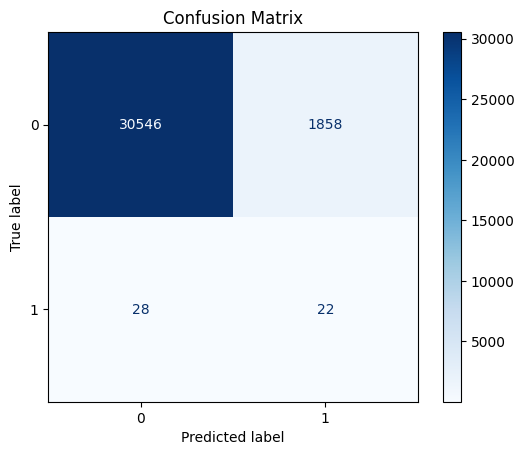

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
final_predict_label = (best_logits > cutoff).astype(int)  # 使用最佳预测值，转换为0和1
final_test_targets = edge_label[~edge_bool].detach().cpu().numpy()  # 真实标签

# 计算混淆矩阵
cm = confusion_matrix(final_test_targets, final_predict_label)

# 绘制混淆矩阵
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])  # 假设二分类问题
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [27]:
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(test_targets, best_logits)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic',fontsize=16, weight='roman')
plt.plot(fpr, tpr, 'orange', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'p--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=14,labelpad=15, weight='roman')
plt.xlabel('False Positive Rate', fontsize=14,labelpad=15, weight='roman')
# plt.savefig(osp.join(plt_dir, 'roc_curve.png'))

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/hrren/miniconda3/envs/pyg/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2380654/719623005.py", line 2, in <module>
    fpr, tpr, threshold = metrics.roc_curve(test_targets, best_logits)
  File "/home/hrren/miniconda3/envs/pyg/lib/python3.9/site-packages/sklearn/metrics/_ranking.py", line 992, in roc_curve
    fps, tps, thresholds = _binary_clf_curve(
  File "/home/hrren/miniconda3/envs/pyg/lib/python3.9/site-packages/sklearn/metrics/_ranking.py", line 747, in _binary_clf_curve
    y_type = type_of_target(y_true, input_name="y_true")
  File "/home/hrren/miniconda3/envs/pyg/lib/python3.9/site-packages/sklearn/utils/multiclass.py", line 298, in type_of_target
    if is_multilabel(y):
  File "/home/hrren/miniconda3/envs/pyg/lib/python3.9/site-packages/sklearn/utils/multiclass.py", line 161, in is_multilabel
    y = xp.asarray(

Text(0.5, 0, 'Epoch')

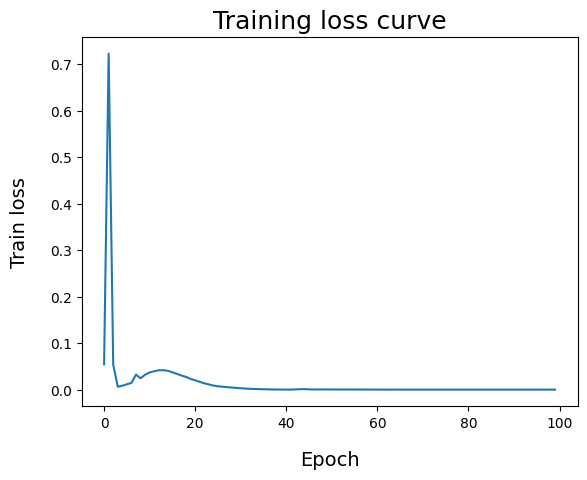

In [28]:
plt.plot(train_loss_list)
plt.title('Training loss curve', fontsize=18, weight='roman')
plt.ylabel('Train loss', fontsize=14,labelpad=15, weight='roman')
plt.xlabel('Epoch', fontsize=14,labelpad=15, weight='roman')
# plt.savefig(osp.join(plt_dir, 'loss_curve.png'))

In [29]:
def plot_confusion_matrix(cm, classes, savename='cm', title='Confusion Matrix'):
    plt.figure(figsize=(8, 6), dpi=100)
    np.set_printoptions(precision=2)

    # 在混淆矩阵中每格的概率值
    ind_array = np.arange(len(classes))
    x, y = np.meshgrid(ind_array, ind_array)
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        c = cm[y_val][x_val]
        if c > 0.001:
            plt.text(x_val, y_val, "%0.0f" % (c,), color='black', fontsize=12, va='center', ha='center')
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title, fontsize=18, pad=15)
    plt.colorbar()
    xlocations = np.array(range(len(classes)))
    plt.xticks(xlocations, classes, rotation=45, fontsize=12)
    plt.yticks(xlocations, classes, fontsize=12)
    plt.ylabel('Actual label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    
    # offset the tick
    tick_marks = np.array(range(len(classes)))
    plt.gca().set_xticks(tick_marks + 0.5, minor=True)
    plt.gca().set_yticks(tick_marks + 0.5, minor=True)
    plt.grid(True, which='minor', linestyle='-')
    plt.gcf().subplots_adjust(bottom=0.2)
    
    # Save the figure
    plt.savefig(f"{savename}.png", format='png', dpi=300, bbox_inches='tight')
    plt.show()
plot_confusion_matrix(cm, classes, savename='confusion_matrix', title='Confusion Matrix')

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/hrren/miniconda3/envs/pyg/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2380654/544396986.py", line 32, in <module>
    plot_confusion_matrix(cm, classes, savename='confusion_matrix', title='Confusion Matrix')
NameError: name 'cm' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/hrren/miniconda3/envs/pyg/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2057, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/hrren/miniconda3/envs/pyg/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1118, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/home/hrren/miniconda3/envs/pyg/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1012, in structured_tracebac

In [30]:
classes = ['notinterction', 'intrection']
plot_confusion_matrix(cm)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/hrren/miniconda3/envs/pyg/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2380654/1717426045.py", line 2, in <module>
    plot_confusion_matrix(cm)
NameError: name 'cm' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/hrren/miniconda3/envs/pyg/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2057, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/hrren/miniconda3/envs/pyg/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1118, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/home/hrren/miniconda3/envs/pyg/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1012, in structured_traceback
    return VerboseTB.structured_traceback(
  File "/home/hrren

Text(0.5, 0, 'Epoch')

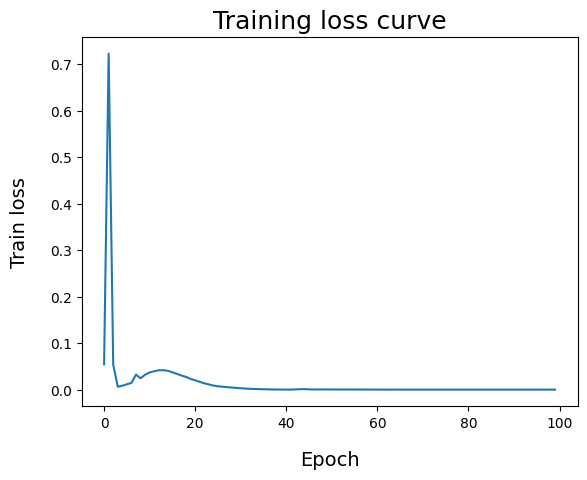

In [31]:
plt.plot(train_loss_list)
plt.title('Training loss curve', fontsize=18, weight='roman')
plt.ylabel('Train loss', fontsize=14,labelpad=15, weight='roman')
plt.xlabel('Epoch', fontsize=14,labelpad=15, weight='roman')
# plt.savefig(osp.join(plt_dir, 'loss_curve.png'))

In [32]:
node_tf_ID = df['TF'].unique().tolist()
TFnode_2_ID_dict = {node:ind for ind, node in enumerate(node_tf_ID)}
json_TFnode_map = osp.join(root_dir, 'TF_node_mapping_dict.pkl')
json.dump(TFnode_2_ID_dict, open(json_TFnode_map, 'w'), indent=4, sort_keys=False, ensure_ascii=False)
node_target_ID = df['Target'].unique().tolist()
target_node_2_ID_dict  = {node:ind for ind, node in enumerate(node_target_ID)}
json_targetnode_map = osp.join(root_dir, 'target_node_mapping_dict.pkl')
json.dump(target_node_2_ID_dict, open(json_targetnode_map, 'w'), indent=4, sort_keys=False, ensure_ascii=False)
len(TFnode_2_ID_dict), len(target_node_2_ID_dict)

(1873, 49279)

In [ ]:
test_rows = combined_data[combined_data['training'] == 'test']